In [1]:
# +
from dataset.semi import SemiDataset
from model.semseg.deeplabv2 import DeepLabV2
from model.semseg.deeplabv3plus import DeepLabV3Plus
from model.semseg.pspnet import PSPNet
from utils import count_params, meanIOU, color_map, Accuracy, DiceCoefficient

from utilsf.loss_file import save_loss
# -

import argparse
from copy import deepcopy
import numpy as np
import os
from PIL import Image
import torch
from torch.nn import CrossEntropyLoss, DataParallel, functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
semi_setting = 'kidney/0114'
save_path = f'outdir/models/{semi_setting}'
pseudo_mask_path = f'outdir/pseudo_masks/{semi_setting}'
labeled_id_path = f'dataset/splits/{semi_setting}/labeled.txt'
reliable_id_path = f'outdir/reliable_ids/{semi_setting}'
data_root = '/home/S312112021/dataset/0_data_dataset_voc_950_kidney'
batch_size = 16
crop_size = 224
plus = True
dataset ='kidney'

if not os.path.exists(save_path):
    os.makedirs(save_path)
if not os.path.exists(pseudo_mask_path):
    os.makedirs(pseudo_mask_path)
if plus and reliable_id_path is None:
    exit('Please specify reliable-id-path in ST++.')

criterion = CrossEntropyLoss(ignore_index=255)

valset = SemiDataset(dataset, data_root, 'val', None)
valloader = DataLoader(valset, batch_size=4 if dataset == 'cityscapes' else 1,
                       shuffle=False, pin_memory=True, num_workers=4, drop_last=False)

In [3]:
MODE = 'train'

trainset = SemiDataset(dataset, data_root, MODE, crop_size, labeled_id_path)
trainset.ids = 2 * trainset.ids if len(trainset.ids) < 200 else trainset.ids
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True,
                         pin_memory=True, num_workers=16, drop_last=True)

In [4]:
def init_basic_elems():
    model_zoo = {'deeplabv3plus': DeepLabV3Plus, 'pspnet': PSPNet, 'deeplabv2': DeepLabV2}
    model = model_zoo['deeplabv3plus']('resnet18', 2 if dataset == 'kidney' else 19)

    head_lr_multiple = 10.0

    optimizer = SGD([{'params': model.backbone.parameters(), 'lr': 0.001},
                     {'params': [param for name, param in model.named_parameters()
                                 if 'backbone' not in name],
                      'lr': 0.001 * head_lr_multiple}],
                    lr=0.001, momentum=0.9, weight_decay=1e-4)

    model = DataParallel(model).cuda()

    return model, optimizer

In [5]:
model, optimizer = init_basic_elems()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
# 定義 Dice loss 函數
def dice_loss(pred, target, smooth=1e-6):
    # 將預測結果應用 softmax 並選取類別 1 的機率
    pred = F.softmax(pred, dim=1)
    
    # 將預測結果和目標轉換為平坦的張量
    pred_flat = pred.contiguous().view(-1)
    target_flat = target.contiguous().view(-1)
    
    # 計算交集和聯集
    intersection = (pred_flat * target_flat).sum()
    union = pred_flat.sum() + target_flat.sum()
    
    # 計算 Dice loss
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

In [7]:
for img, mask in trainloader:
    img, mask = img.to(device), mask.to(device)
    pred = model(img)  
#     pred = torch.argmax(pred, dim=1)  
#     pred = F.softmax(pred, dim=1)
    break

In [8]:
print('img shape: ', img.shape)
print('mask shape: ', mask.shape)
print('pred shape: ', pred.shape)

# 檢查 masks 的最小值和最大值
print('mask min value: ', mask.min().item())
print('mask max value: ', mask.max().item())

print('pred min value: ', pred.min().item())
print('pred max value: ', pred.max().item())

img shape:  torch.Size([16, 3, 224, 224])
mask shape:  torch.Size([16, 224, 224])
pred shape:  torch.Size([16, 2, 224, 224])
mask min value:  0
mask max value:  1
pred min value:  -3.0463500022888184
pred max value:  3.4024453163146973


In [9]:
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)


pred = pred[:, 1, :, :]  # 假設第二個通道是我們關注的類別    
# loss = criterion(pred, mask)
loss = dice_loss(pred, mask)

print('Loss: ', loss.item())

Loss:  0.9916408658027649


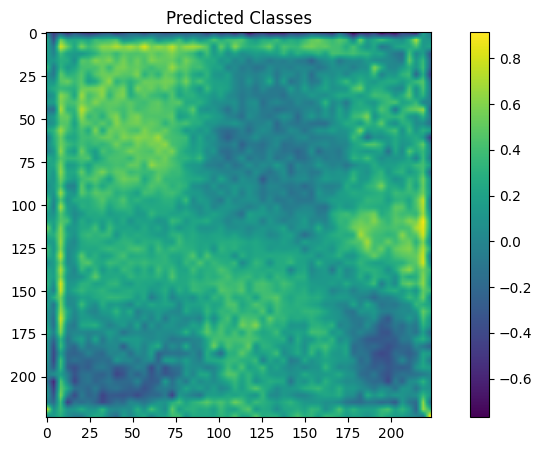

In [10]:
import matplotlib.pyplot as plt
from torch.nn import CrossEntropyLoss, DataParallel, functional as F


# 可視化 pred_classes 的第一個樣本
pred_class_sample = pred[0].detach().cpu().numpy()

plt.figure(figsize=(10, 5))
plt.imshow(pred_class_sample, cmap='viridis')
plt.colorbar()
plt.title('Predicted Classes')
plt.show()